In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plot
import seaborn as sb
import os

In [ ]:
# Import data
# url = 'https://github.gatech.edu/raw/dgreer33/CS4641Project/main/PitchData.csv?token=GHSAT0AAAAAAAADCMCEEIWF636LWURBPZ4KZUDAVKQ'
#from google.colab import files
#uploaded = files.upload()
data = pd.read_csv('PitchData.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24128 entries, 0 to 24127
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pitcher_ID         24128 non-null  int64  
 1   Pitcher            24128 non-null  object 
 2   Pitcher_Throws     24128 non-null  object 
 3   Batter_ID          24128 non-null  int64  
 4   Batter             24128 non-null  object 
 5   Batter_Hits        24128 non-null  object 
 6   Game_Date          24128 non-null  object 
 7   Top_Bot            24128 non-null  int64  
 8   Inning             24128 non-null  int64  
 9   Balls              24107 non-null  float64
 10  Strikes            24107 non-null  float64
 11  Outs               24107 non-null  float64
 12  Pitch_Outcome      24128 non-null  object 
 13  Pitch_Type         24128 non-null  object 
 14  release_speed      24128 non-null  float64
 15  x_movement         24128 non-null  float64
 16  z_movement         241

In [ ]:
# Drop missing data
clean_data = data.dropna()
# Drop rows with "Undefined" and "Other" in Pitch_Type column
clean_data = clean_data[~clean_data['Pitch_Type'].isin(['Undefined', 'Other'])]
# Drop irrelevant columns
clean_data = clean_data.drop(["Pitcher_ID","Batter_ID", "Pitcher", "Batter", "Game_Date", "Top_Bot", "Inning", "Balls", "Strikes", "Outs"], axis=1)

# Use OneHotEncoding to encode categorical features as numeric values
categorical_features = ['Pitch_Outcome', 'Pitcher_Throws', 'Batter_Hits']
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(clean_data[categorical_features])

encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Combing the encoded features with the original data
clean_data = pd.concat([clean_data, encoded_df], axis=1)

# Drop old categegorical features
clean_data = clean_data.drop(categorical_features, axis=1)

In [ ]:
clean_data = clean_data.dropna()
clean_data.isna().sum()

Pitch_Type                      0
release_speed                   0
x_movement                      0
z_movement                      0
release_spin_rate               0
spin_dir                        0
release_pos_x                   0
release_pos_z                   0
release_extension               0
plate_x                         0
plate_z                         0
Pitch_Outcome_BallCalled        0
Pitch_Outcome_FoulBall          0
Pitch_Outcome_HitByPitch        0
Pitch_Outcome_InPlay            0
Pitch_Outcome_StrikeCalled      0
Pitch_Outcome_StrikeSwinging    0
Pitch_Outcome_Undefined         0
Pitcher_Throws_L                0
Pitcher_Throws_R                0
Batter_Hits_L                   0
Batter_Hits_R                   0
dtype: int64

In [ ]:
# Split data into dependent/independent variables
x = clean_data.drop(columns=('Pitch_Type'))
y = clean_data.Pitch_Type
# Normalize data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [ ]:
# Test/Train Split
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=.25, train_size=.75, random_state=0)

In [ ]:
# Train Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
# Prediction
rf_prediction = rf_model.predict(X_test)
rf_prediction_prob = rf_model.predict_proba(X_test)

In [ ]:
# Results
accuracy = accuracy_score(y_test, rf_prediction)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9690206528980679


In [ ]:
# Feature Importance
feature_importance = pd.DataFrame({'Feature': x.columns, 'Importance': rf_model.feature_importances_})
print(feature_importance.sort_values(by='Importance', ascending=False))

                         Feature  Importance
0                  release_speed    0.230248
2                     z_movement    0.192268
3              release_spin_rate    0.141518
4                       spin_dir    0.116139
1                     x_movement    0.099727
5                  release_pos_x    0.071329
6                  release_pos_z    0.049391
7              release_extension    0.025746
9                        plate_z    0.018852
18              Pitcher_Throws_R    0.018193
17              Pitcher_Throws_L    0.015014
8                        plate_x    0.012927
19                 Batter_Hits_L    0.001478
10      Pitch_Outcome_BallCalled    0.001354
20                 Batter_Hits_R    0.001339
13          Pitch_Outcome_InPlay    0.001160
11        Pitch_Outcome_FoulBall    0.001078
15  Pitch_Outcome_StrikeSwinging    0.001056
14    Pitch_Outcome_StrikeCalled    0.001056
12      Pitch_Outcome_HitByPitch    0.000080
16       Pitch_Outcome_Undefined    0.000046


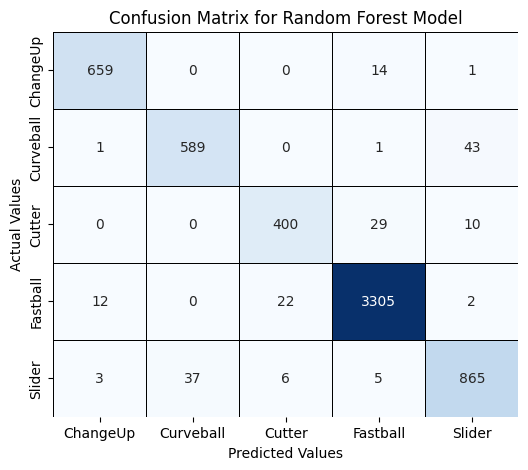

In [ ]:
# Display Confusion Matrix
confusion = confusion_matrix(y_test, rf_prediction)
plot.figure(figsize=(6, 5))
sb.heatmap(confusion, annot=True, fmt=".0f", xticklabels=rf_model.classes_, yticklabels=rf_model.classes_, cmap='Blues', cbar=False, linewidth=0.5, linecolor='Black')
plot.title('Confusion Matrix for Random Forest Model')
plot.ylabel('Actual Values')
plot.xlabel('Predicted Values')
plot.show()

In [ ]:
# ROC Curve
classes = np.unique(y_test)
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], rf_prediction_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

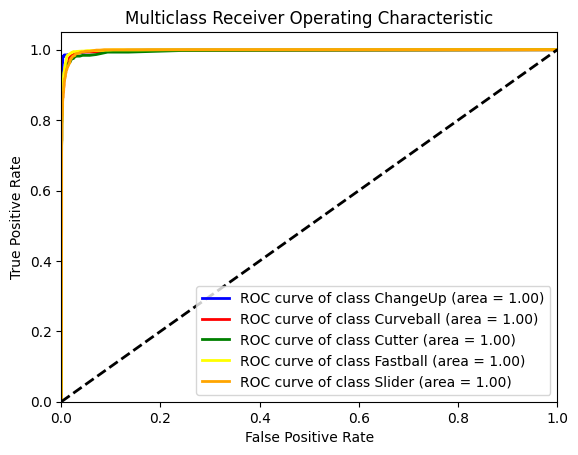

In [ ]:
# Plot ROC curves
plot.figure()
colors = ['blue', 'red', 'green', 'yellow', 'orange']
for i, color in zip(range(n_classes), colors):
    plot.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plot.plot([0, 1], [0, 1], 'k--', lw=2)
plot.xlim([0.0, 1.0])
plot.ylim([0.0, 1.05])
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.title('Multiclass Receiver Operating Characteristic')
plot.legend(loc="lower right")
plot.show()